In [1]:
!pip install tensorflow
!pip install opencv-python opencv-python-headless opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 16.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [01:13<00:00, 162MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [4]:
train_dir = os.path.join(path, "Train")
test_dir = os.path.join(path, "Test")

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]
num_classes = len(classes)



In [18]:
img_width, img_height = 64, 64

def balance_dataset(directory, classes, max_samples_per_class=7140):
    X, y = [], []
    class_to_label = {class_name: i for i, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        image_files = os.listdir(class_dir)[:max_samples_per_class]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = image / 255.0
                X.append(image)
                y.append(class_to_label[class_name])

    return np.array(X), np.array(y)

X_train, y_train = balance_dataset(train_dir, classes)
X_test, y_test = balance_dataset(test_dir, classes)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [23]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [24]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [25]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 222s 124ms/step - accuracy: 0.4276 - loss: 1.3173 - val_accuracy: 0.7917 - val_loss: 0.5524
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 220s 123ms/step - accuracy: 0.7679 - loss: 0.6466 - val_accuracy: 0.9147 - val_loss: 0.2729
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 220s 123ms/step - accuracy: 0.8555 - loss: 0.4158 - val_accuracy: 0.9389 - val_loss: 0.1888
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 220s 123ms/step - accuracy: 0.8964 - loss: 0.3115 - val_accuracy: 0.9479 - val_loss: 0.1582
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 122ms/step - accuracy: 0.9129 - loss: 0.2561 - val_accuracy: 0.9629 - val_loss: 0.1141
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.9277 - loss: 0.2192 - val_accuracy: 0.9731 - val_loss: 0.0921
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.9290 - loss: 0.2004 - val_accuracy: 0.9608 - val_loss: 0.1225
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - ac

In [26]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9821 - loss: 0.0613
Train Accuracy: 96.25%
Test Accuracy: 98.21%


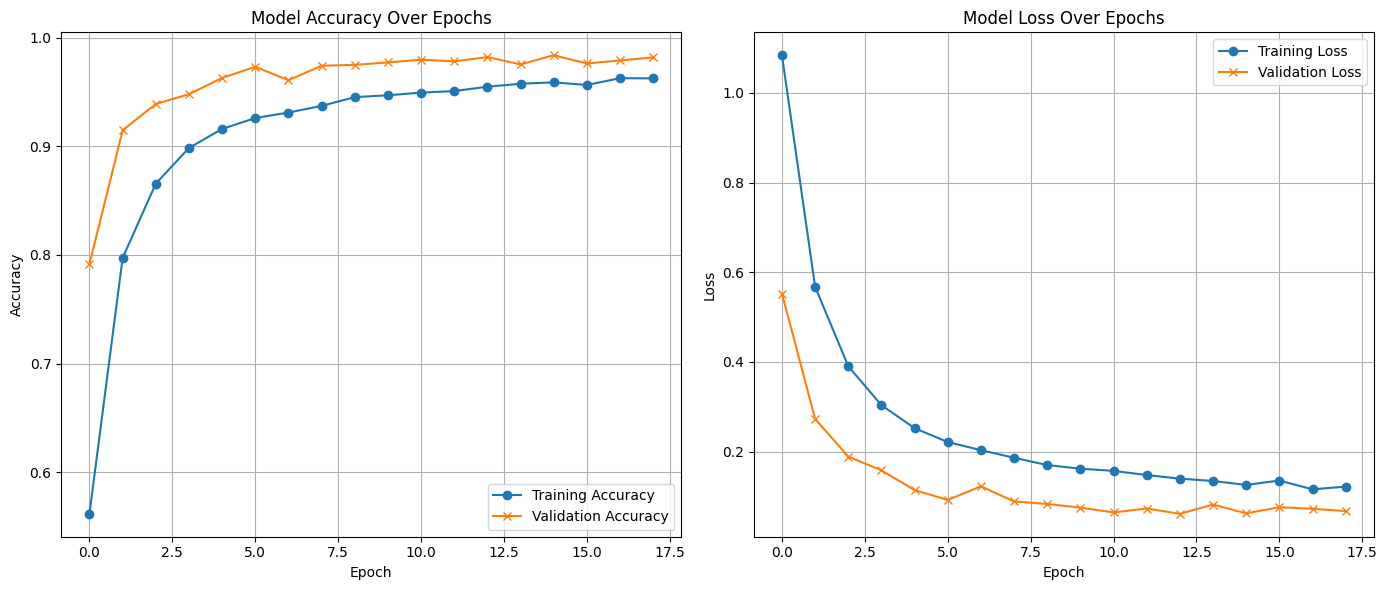

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


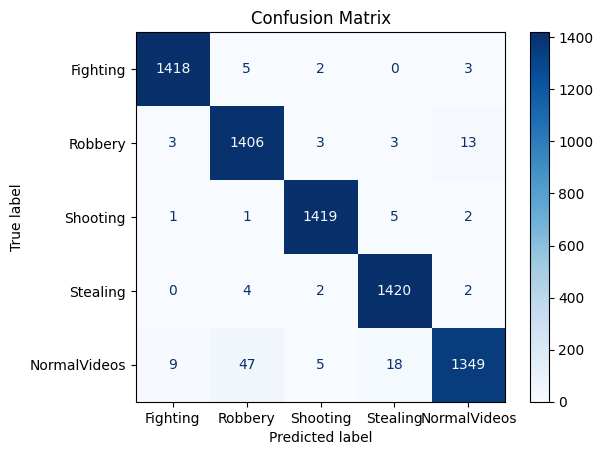

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
### reduce dropout to 0.3 

### Reduce DropOut

In [28]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 222s 123ms/step - accuracy: 0.4460 - loss: 1.2889 - val_accuracy: 0.7868 - val_loss: 0.5989
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.7997 - loss: 0.5650 - val_accuracy: 0.9269 - val_loss: 0.2318
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.8913 - loss: 0.3182 - val_accuracy: 0.9564 - val_loss: 0.1396
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 218s 122ms/step - accuracy: 0.9222 - loss: 0.2254 - val_accuracy: 0.9546 - val_loss: 0.1426
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 218s 122ms/step - accuracy: 0.9347 - loss: 0.1913 - val_accuracy: 0.9714 - val_loss: 0.0891
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.9430 - loss: 0.1744 - val_accuracy: 0.9665 - val_loss: 0.1163
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 218s 122ms/step - accuracy: 0.9488 - loss: 0.1585 - val_accuracy: 0.9791 - val_loss: 0.0660
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.9

In [31]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9857 - loss: 0.0568
Train Accuracy: 97.46%
Test Accuracy: 98.63%


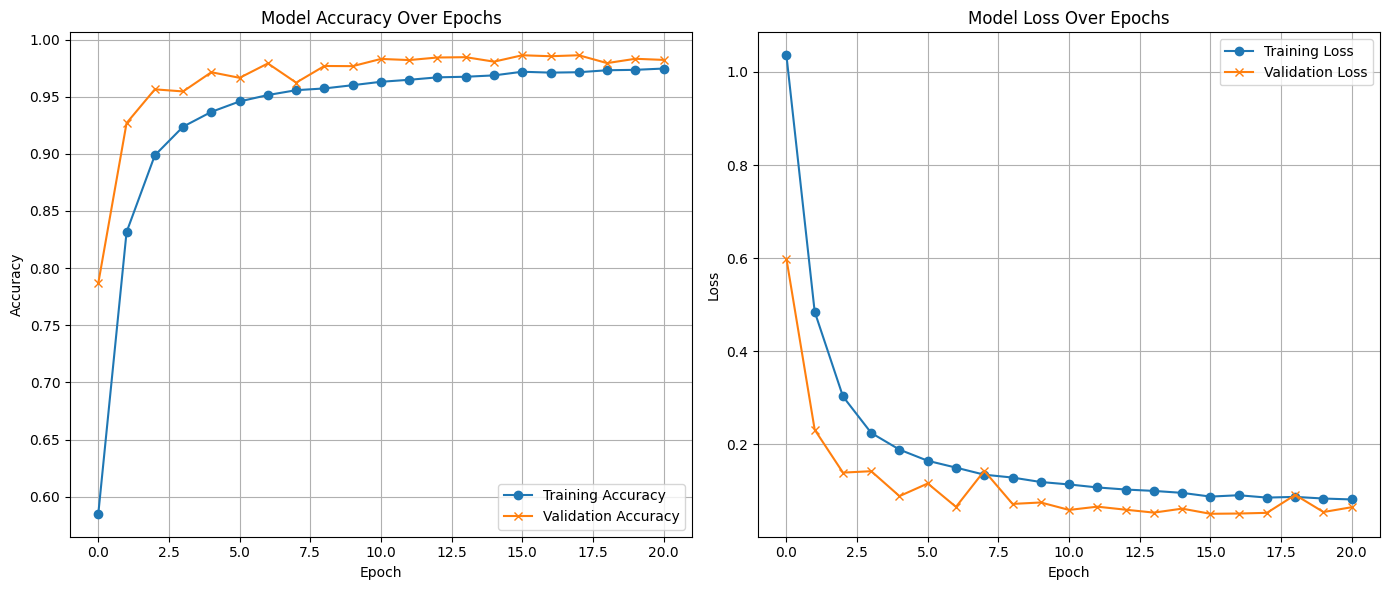

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


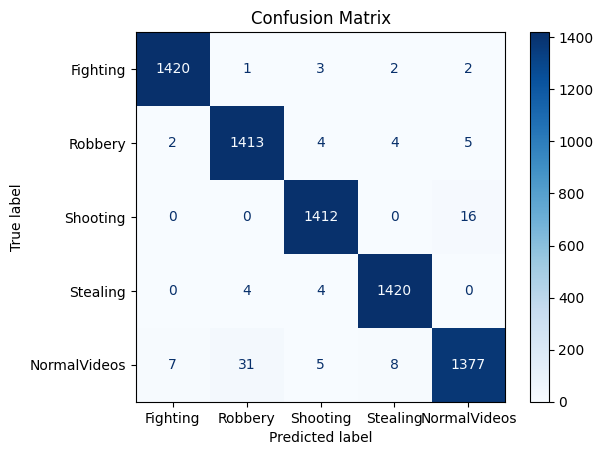

In [33]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


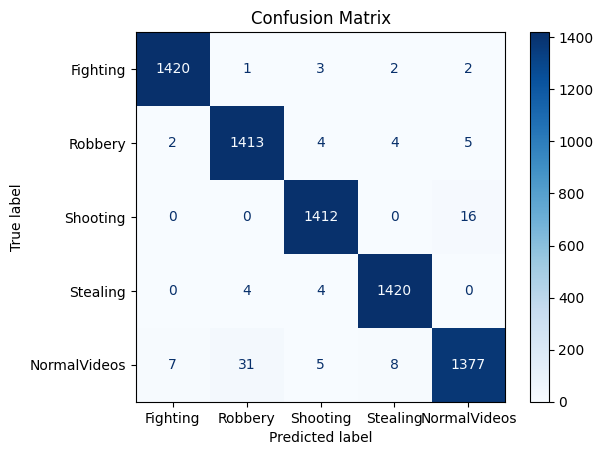

العلامة المتوقعة للصورة 0: Stealing
العلامة الحقيقية للصورة 0: Stealing


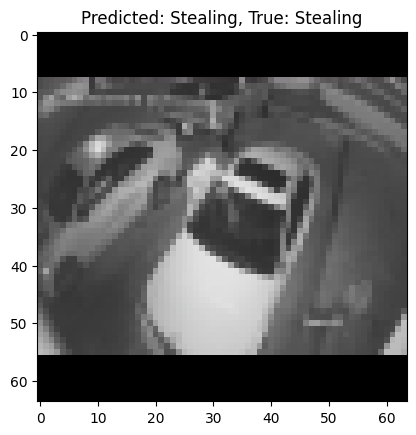

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model



y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

image_index = 0  
predicted_label = classes[y_pred[image_index]]  
true_label = classes[y_test[image_index]]

print(f"العلامة المتوقعة للصورة {image_index}: {predicted_label}")
print(f"العلامة الحقيقية للصورة {image_index}: {true_label}")

plt.imshow(X_test[image_index]) 
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [36]:
model.save('cnn_model.keras')